In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as statsm
import numpy as np
import sklearn.covariance as cov
import scipy.stats as stats
import sklearn.neighbors as neighb
import sklearn.preprocessing as prep
import matplotlib.gridspec as gspec
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import graphviz
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.preprocessing import MinMaxScaler
from math import ceil
import plotly.express as px

In [2]:
# Functions to be used later

def get_ss(df):
    
    ss = np.sum(df.var() * (df.count() - 1))
    
    return ss

def rsq(df,list_of_columns):

    sst = get_ss(df[list_of_columns])
    ssw_labels = df[list_of_columns + ["cluster"]].groupby(by='cluster').apply(get_ss)
    ssb = sst - np.sum(ssw_labels)
    r2 = ssb / sst

    display('rsq is:', r2)

def get_r2_hc(df, link, max_nclus, min_nclus=1, dist="euclidean"):
    """
    This function calculates the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on the fact that the Sum of squares (SSt) of all the data
    can be decomposed into the sum of SS within clusters (SSw) and SS between clusters (SSb): SSt = SSw + SSb. The R2 is the ratio between
    SSb and SSt: R2 = SSb/SSt. The higher the R2 the better the solution since SSw will be close to 0 which indicated perfect homogeneous
    clusters.
    """

    def get_ss(matrix):
        mc = matrix - matrix.mean(axis=0)
        return (mc.T@mc).trace() #return sum of squares of matrix
    
    matrix = df.values
    ncols = matrix.shape[1]
    sst = get_ss(matrix) #get total sum of squares
    
    r2 = np.array([]) #where we will store the R2 metrics
    
    for i in range(min_nclus, max_nclus+1):
        Hclustering = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link)
        hclabels = Hclustering.fit_predict(matrix) #get cluster labels
        concat = np.concatenate((matrix, np.expand_dims(hclabels,1)), axis=1)
        ssw = np.array([get_ss(concat[concat[:,ncols]==j, :ncols]) for j in range(i)]).sum() #calculate ssw for a given cluster solution
        r2 = np.append(r2, (sst-ssw)/sst) #save the R2 of the given cluster solution
        
    return r2

    
def kelbowplots(clus_estim, data):
    """
    This function produces the k-elbow plot for a given clustering estimator according to 3 different clustering quality measures: "Distortion", "Silhouette" and "Calinski Harabasz".
    """
    sns.set()
    fig, axes = plt.subplots(1, 3, figsize=(20,7))

    # Plot the data
    metrics = ["distortion", "silhouette", "calinski_harabasz"]
    ylabels = ["Distortion measure", "Silhouette measure", "Calinski Harabasz measure"]
    titles = ["Distortion measure plot", "Silhouette measure plot", "Calinski Harabasz measure plot"]
    for ax, m, yl, tl in zip(axes.flatten(), metrics, ylabels, titles):
        # KElbowVisualizer produces the elbow plot for several quality measures
        KElbowVisualizer(clus_estim, metric=m, timings=False, locate_elbow=True, ax=ax).fit(data)
        ax.invert_xaxis()
        ax.set_ylabel(yl, fontsize=13)
        ax.set_xlabel("Number of clusters", fontsize=13)
        ax.set_title(tl, fontsize=13)

    # Set figure
    plt.suptitle("K-Elbow Plots", fontsize=23)

    plt.show()

In [3]:
df = pd.read_csv('final_data_for_bi_dwct.csv')

In [4]:
df

,Unnamed: 0,Quarter,POS_ID,ProductPackSKU_ID,Total_Value,Total_Units,Purchased_Units,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID
0,0,2016Q1,359,4835,379062.0,599,112,15,3,828,1581
1,1,2016Q1,410,754,228068.0,490,106,9,178,127,231
2,2,2016Q1,208,4835,217423.0,311,102,15,3,828,1581
3,3,2016Q1,355,4835,191877.0,283,101,15,3,828,1581
4,4,2016Q1,239,755,295200.0,675,100,9,178,127,231
...,...,...,...,...,...,...,...,...,...,...,...
8067680,8067680,2019Q4,311,30,19130.0,2,1,21,109,638,9
8067681,8067681,2019Q4,194,6795,1147.0,1,1,9,178,1179,2217
8067682,8067682,2019Q4,64,2471,1075.0,1,1,21,78,427,826
8067683,8067683,2019Q4,311,46,1655.0,1,1,21,39,4,18


In [5]:
clus = df.groupby(['POS_ID']).agg({'Total_Value': 'sum','Total_Units':'sum','Purchased_Units':'sum'})
clus

,Total_Value,Total_Units,Purchased_Units
POS_ID,,,
1,9.786703e+08,609151,190460
2,6.355349e+08,390484,179902
3,1.048120e+09,602120,274824
4,1.261300e+09,797480,384828
5,6.681779e+08,423022,231715
...,...,...,...
406,7.867554e+08,494233,196190
407,1.264067e+09,784910,282026
408,7.078634e+08,456295,185697


In [6]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(clus),columns = clus.columns)
df_scaled

,Total_Value,Total_Units,Purchased_Units
0,0.373938,0.386954,0.294253
1,0.219563,0.223465,0.269177
2,0.405183,0.381698,0.494622
3,0.501091,0.527761,0.755887
4,0.234249,0.247793,0.392235
...,...,...,...
405,0.287596,0.301035,0.307862
406,0.502336,0.518363,0.511727
407,0.252103,0.272670,0.282940
408,0.257229,0.264484,0.278487


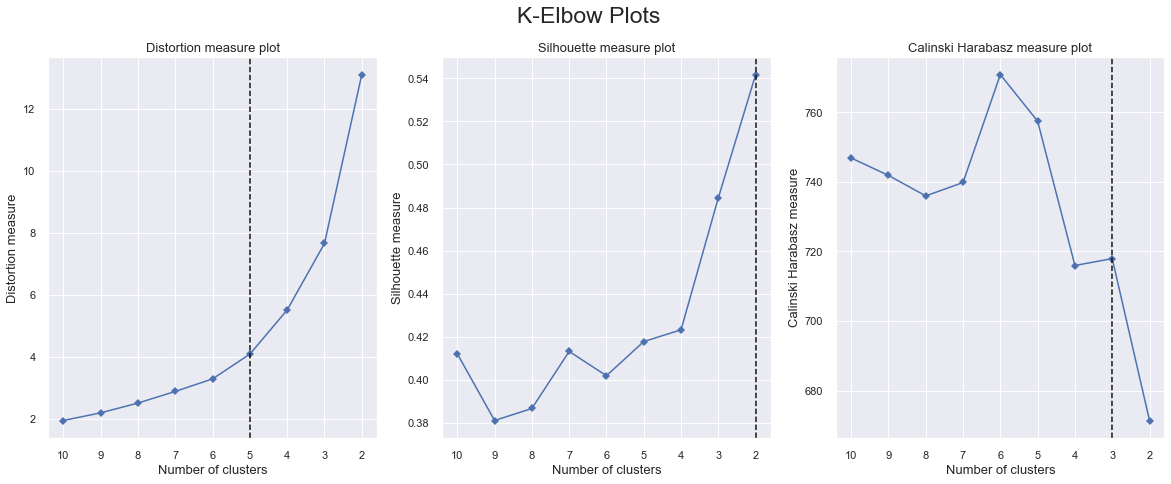

In [7]:
# Instantiate a scikit-learn K-Means model for taste_prof variables
clus_estim = KMeans(random_state=1)
# K-elbow plots
#kelbowplots(clus_estim, df_rec_sca[vc_custo_alt+vc_taste_alt])
kelbowplots(clus_estim, df_scaled)

In [7]:
def kmeans_clustering(df,nclusters):
    
    # Clustering
    clustering = KMeans(n_clusters=nclusters, init='k-means++', n_init=15, random_state=1)
    clustering.fit(df)
    df['cluster'] = clustering.labels_
    
    return df

In [8]:
df_clustered_value = kmeans_clustering(df_scaled,3)

In [9]:
df_clustered_value

,Total_Value,Total_Units,Purchased_Units,cluster
0,0.373938,0.386954,0.294253,0
1,0.219563,0.223465,0.269177,1
2,0.405183,0.381698,0.494622,0
3,0.501091,0.527761,0.755887,2
4,0.234249,0.247793,0.392235,0
...,...,...,...,...
405,0.287596,0.301035,0.307862,0
406,0.502336,0.518363,0.511727,2
407,0.252103,0.272670,0.282940,1
408,0.257229,0.264484,0.278487,1


In [10]:
df_clustered_value.groupby(df_clustered_value['cluster']).mean()

,Total_Value,Total_Units,Purchased_Units
cluster,,,
0,0.325519,0.336399,0.432593
1,0.157069,0.160987,0.212965
2,0.549779,0.564369,0.659615


In [11]:
df_clustered_value['Total_Value'].groupby(df_clustered_value['cluster']).count()

cluster
0    159
1    185
2     66
Name: Total_Value, dtype: int64

In [12]:
df_prod=df[['ProductFamily_ID','POS_ID']]
df_prod.head()

,ProductFamily_ID,POS_ID
0,15,359
1,9,410
2,15,208
3,15,355
4,9,239


In [13]:
# Turn my column into a dummy value
dummy2 = pd.get_dummies(df_prod['ProductFamily_ID'])
# Take a look
dummy2

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8067680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8067681,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8067682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8067683,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
df_prod= pd.concat ([dummy2,df_prod['POS_ID']],axis=1)

In [15]:
df_prod

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,POS_ID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,359
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,410
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,208
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,355
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8067680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,311
8067681,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,194
8067682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,64
8067683,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,311


In [16]:
clus = df_prod.groupby(['POS_ID']).agg('mean')
clus

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
POS_ID,,,,,,,,,,,,,,,,,,,,,
1,0.153262,0.025060,0.004856,0.001005,0.002121,0.011944,0.002679,0.007088,0.164369,0.007200,...,0.212089,0.002679,0.006418,0.043813,0.010214,0.000837,0.017135,0.000447,0.001060,0.323827
2,0.163561,0.028771,0.005513,0.001141,0.002091,0.011597,0.002155,0.007541,0.190558,0.008302,...,0.247402,0.002788,0.007161,0.047719,0.011090,0.000760,0.019645,0.000507,0.001204,0.237896
3,0.154999,0.023801,0.004336,0.001638,0.001686,0.011419,0.002602,0.006649,0.171525,0.006119,...,0.212238,0.002072,0.005974,0.043845,0.010118,0.001060,0.015707,0.000385,0.000723,0.320694
4,0.139153,0.018454,0.003399,0.000672,0.001606,0.011170,0.001905,0.005529,0.142590,0.005155,...,0.188277,0.001793,0.004856,0.031230,0.007471,0.001083,0.012776,0.000336,0.001121,0.419552
5,0.159962,0.026084,0.005081,0.000838,0.002357,0.012675,0.002567,0.007019,0.183794,0.006966,...,0.231196,0.002462,0.006233,0.044417,0.010842,0.001100,0.016394,0.000419,0.001205,0.275875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,0.122111,0.033610,0.005707,0.001339,0.002325,0.011979,0.003171,0.007328,0.145434,0.007046,...,0.187218,0.003100,0.007751,0.052072,0.013388,0.001762,0.020786,0.000493,0.001973,0.367742
407,0.122799,0.026160,0.004746,0.001269,0.001821,0.009382,0.002649,0.005685,0.136873,0.006181,...,0.185993,0.002649,0.006623,0.041172,0.010597,0.001435,0.017495,0.000442,0.001490,0.411667
408,0.138067,0.033016,0.005857,0.001757,0.002343,0.009297,0.003367,0.007101,0.142753,0.008565,...,0.205344,0.003221,0.008638,0.051391,0.013104,0.001611,0.020278,0.001098,0.001318,0.338433


In [74]:
clus=clus[[1,9,12,21]]

In [17]:
clus.sum(axis=1)

POS_ID
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
      ... 
406    1.0
407    1.0
408    1.0
409    1.0
410    1.0
Length: 410, dtype: float64

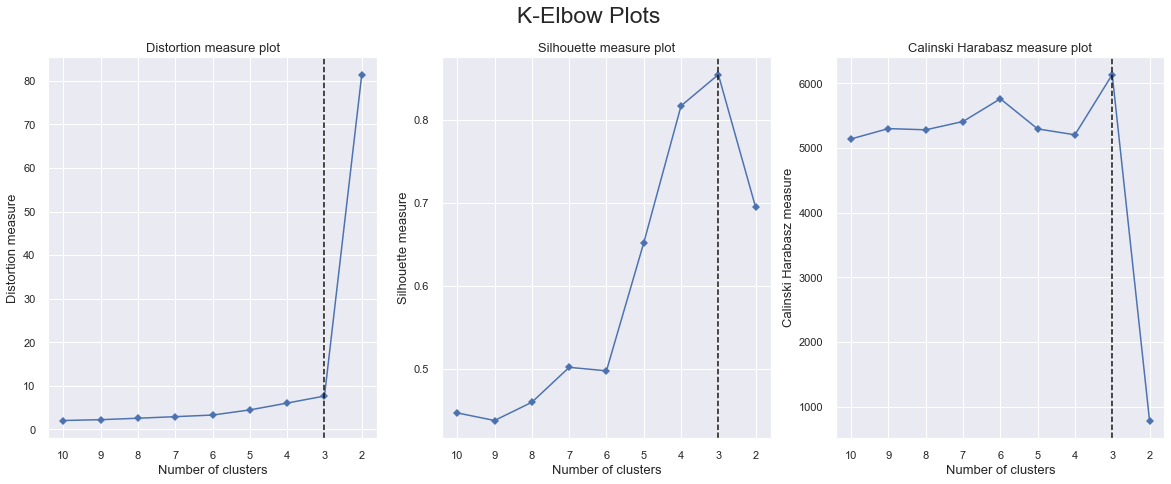

In [76]:
# Instantiate a scikit-learn K-Means model for taste_prof variables
clus_estim = KMeans(random_state=1)
# K-elbow plots
#kelbowplots(clus_estim, df_rec_sca[vc_custo_alt+vc_taste_alt])
kelbowplots(clus_estim, df_scaled)

In [20]:
scaler_fam = MinMaxScaler()
df_scaled_fam = pd.DataFrame(scaler_fam.fit_transform(clus),columns = clus.columns)
df_scaled_fam

,1,2,3,4,5,6,7,8,9,10,...,13,14,15,16,17,18,19,20,21,cluster
0,0.612466,0.362150,0.433331,0.215970,0.395605,0.547665,0.310351,0.329977,0.552801,0.313964,...,0.345249,0.280037,0.474451,0.476189,0.213420,0.319169,0.026262,0.135007,0.408209,1.0
1,0.715460,0.483074,0.564385,0.288683,0.384211,0.512775,0.170725,0.389373,0.755558,0.442325,...,0.376776,0.362915,0.573464,0.575224,0.181137,0.464095,0.034437,0.192058,0.220705,0.0
2,0.629832,0.321137,0.329813,0.554557,0.228535,0.494876,0.289786,0.272380,0.608204,0.188040,...,0.170132,0.230475,0.475255,0.465370,0.307149,0.236764,0.018009,0.000840,0.401374,1.0
3,0.471377,0.146875,0.143103,0.038420,0.197776,0.469811,0.104310,0.125486,0.384187,0.075756,...,0.089767,0.105669,0.155444,0.166224,0.316975,0.067563,0.011352,0.158943,0.617088,0.5
4,0.679467,0.395529,0.478161,0.126939,0.486384,0.621213,0.280397,0.320851,0.703195,0.286749,...,0.282596,0.259330,0.489748,0.547222,0.323957,0.276437,0.022547,0.192311,0.303576,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,0.300950,0.640800,0.603075,0.394556,0.474175,0.551145,0.441293,0.361426,0.406203,0.296064,...,0.466752,0.428759,0.683821,0.834938,0.602300,0.529975,0.032580,0.497507,0.504036,1.0
406,0.307832,0.398011,0.411543,0.357467,0.280419,0.290117,0.302399,0.145923,0.339921,0.195304,...,0.336636,0.302853,0.407498,0.519460,0.464900,0.340002,0.025589,0.305711,0.599882,0.5
407,0.460515,0.621430,0.632785,0.618047,0.480847,0.281551,0.493666,0.331654,0.385443,0.473024,...,0.501574,0.527826,0.666565,0.802854,0.538768,0.500640,0.114350,0.237210,0.440082,1.0
408,0.437593,0.583350,0.770205,0.425921,0.485086,0.293346,0.497887,0.307103,0.425951,0.452014,...,0.590791,0.524155,0.596246,0.876331,0.294414,0.467938,1.000000,0.298113,0.435855,1.0


In [21]:
df_clustered_prod = kmeans_clustering(df_scaled_fam,3)

In [22]:
df_clustered_prod.groupby(df_clustered_prod['cluster']).mean()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.705290,0.541951,0.512791,0.360675,0.502844,0.576633,0.441423,0.487388,0.635281,0.472075,...,0.732708,0.444192,0.422585,0.553558,0.497744,0.409314,0.538044,0.043310,0.367090,0.271904
1,0.344966,0.194023,0.189016,0.168110,0.191259,0.367030,0.197412,0.168238,0.277610,0.174223,...,0.346796,0.148001,0.135713,0.203110,0.192965,0.414658,0.171338,0.019814,0.249472,0.686063
2,0.556859,0.341551,0.336029,0.242285,0.313121,0.514563,0.294419,0.291656,0.472637,0.307091,...,0.534514,0.257174,0.249359,0.379431,0.337654,0.425625,0.319380,0.031320,0.292584,0.474073


In [18]:
df_clustered_prod = kmeans_clustering(clus,3)

In [19]:
df_clustered_prod.groupby(df_clustered_prod['cluster']).mean()

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.162545,0.030577,0.005254,0.001275,0.002400,0.012232,0.003171,0.008289,0.175022,0.008557,...,0.233859,0.003022,0.007696,0.046933,0.010404,0.001303,0.020926,0.000573,0.001645,0.261360
1,0.126508,0.019964,0.003646,0.000919,0.001598,0.010135,0.002267,0.005896,0.128689,0.006037,...,0.175394,0.002009,0.005157,0.033207,0.007745,0.001309,0.014615,0.000402,0.001361,0.450921
2,0.147833,0.024409,0.004360,0.001052,0.001902,0.011633,0.002612,0.006771,0.154267,0.007121,...,0.204042,0.002365,0.006126,0.040036,0.008969,0.001347,0.017123,0.000482,0.001449,0.353605


In [24]:
df_3=df_clustered_prod.groupby(df_clustered_prod['cluster']).count()
df_3

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
cluster,,,,,,,,,,,,,,,,,,,,,
0,121,121,121,121,121,121,121,121,121,121,...,121,121,121,121,121,121,121,121,121,121
1,122,122,122,122,122,122,122,122,122,122,...,122,122,122,122,122,122,122,122,122,122
2,167,167,167,167,167,167,167,167,167,167,...,167,167,167,167,167,167,167,167,167,167


In [25]:
df_clustered_prod=df_clustered_prod.reset_index()
df_clustered_final= df_clustered_value[['Total_Value','cluster']]
#df_clustered_final['cluster_value']=df_clustered_value['cluster']
df_clustered_final['cluster_prod']=df_clustered_prod['cluster']
df_clustered_final['cluster_merge']=df_clustered_final['cluster'].astype(str)+df_clustered_final['cluster_prod'].astype(str)
df_clustered_final['POS_ID']=0
for i in range(len(df_clustered_final)):
    df_clustered_final['POS_ID'][i]=i+1
df_clustered_final

<ipython-input-25-f7218b16b6a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustered_final['cluster_prod']=df_clustered_prod['cluster']
<ipython-input-25-f7218b16b6a3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustered_final['POS_ID'][i]=i+1


,Total_Value,cluster,cluster_prod,cluster_merge,POS_ID
0,0.373938,0,2,02,1
1,0.219563,1,0,10,2
2,0.405183,0,2,02,3
3,0.501091,2,1,21,4
4,0.234249,0,0,00,5
...,...,...,...,...,...
405,0.287596,0,2,02,406
406,0.502336,2,1,21,407
407,0.252103,1,2,12,408
408,0.257229,1,2,12,409


In [26]:
df_clustered_final.groupby(df_clustered_final['cluster_merge']).count()

,Total_Value,cluster,cluster_prod,POS_ID
cluster_merge,,,,
00,19,19,19,19
01,45,45,45,45
02,95,95,95,95
10,102,102,102,102
11,30,30,30,30
12,53,53,53,53
21,47,47,47,47
22,19,19,19,19


In [28]:
melted_cust_broad = pd.melt(df_clustered_prod.groupby(df_clustered_prod['cluster']).mean().reset_index(),\
#id_vars= ['cluster'], value_vars= [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,17,18,19,20,21])
id_vars= ['cluster'], value_vars= [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,17,18,19,20,21])#[1,9,12,21]

In [82]:
melted_cust_broad['value'].min()
for i in range(len(melted_cust_broad)):
    melted_cust_broad['value'][i]=(melted_cust_broad['value'][i]-melted_cust_broad['value'].min())/(melted_cust_broad['value'].max()-melted_cust_broad['value'].min())
melted_cust_broad

<ipython-input-82-d6f1928ee12b>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cluster,variable,value
0,0,1,0.088164
1,1,1,0.202581
2,2,1,0.252752
3,0,9,0.277154
4,1,9,0.217095
5,2,9,0.261675
6,0,12,0.375195
7,1,12,0.290389
8,2,12,0.347335
9,0,21,1.000000


In [37]:
fig_cust = px.line(melted_cust_broad, x = "variable", y = "value", color = 'cluster', title='Product families percentage of presence in orders of clusters',\
                   height=600, width=900, ).update_traces(mode='lines+markers') #y_title = '% of orders with that Product Family (Unscaled)'
fig_cust.show()

In [41]:
df_clustered_value.rename({'Purchased_Units': 'Purchases_Made'}, axis=1, inplace=True)

In [42]:
df_clustered_value.groupby(df_clustered_value['cluster']).mean()

,Total_Value,Total_Units,Purchases_Made
cluster,,,
0,0.325519,0.336399,0.432593
1,0.157069,0.160987,0.212965
2,0.549779,0.564369,0.659615


In [43]:
melted_numerical = pd.melt(df_clustered_value.groupby(df_clustered_value['cluster']).mean().reset_index(),\
#id_vars= ['cluster'], value_vars= [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,17,18,19,20,21])
id_vars= ['cluster'], value_vars= ['Total_Value', 'Total_Units', 'Purchases_Made'])#[1,9,12,21]

In [44]:
melted_numerical.head()

,cluster,variable,value
0,0,Total_Value,0.325519
1,1,Total_Value,0.157069
2,2,Total_Value,0.549779
3,0,Total_Units,0.336399
4,1,Total_Units,0.160987


In [45]:
fig_cust = px.line(melted_numerical, x = "variable", y = "value", color = 'cluster', title='Numerical Variables cluster analysis',\
                   height=600, width=900, ).update_traces(mode='lines+markers') #y_title = '% of orders with that Product Family (Unscaled)'
fig_cust.show()